# LSTM

* memory lets it evaluate entire, variable length sequences
* add data augmentation to supplement the minority class
* PyTorch convenient features for packing/padding variable length sequences and data augmentation

In [1]:
from dotenv import load_dotenv
import sys
import warnings

from __init__ import get_base_path
import data.load_data as load_data
from model_utils import FeatureStore, grab_bag_train_test_split, pad_collate, SignalClassificationDataset, AugmentMinorityClass, DynamicLSTM

import numpy as np
import os
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import auc, accuracy_score, precision_score, recall_score, f1_score, \
    confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay, classification_report, \
    roc_curve, RocCurveDisplay

import torch
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence, pad_packed_sequence
from torch.utils.data import Dataset, DataLoader, ConcatDataset, Subset
import torch.nn.functional as F
import torch.optim as optim

load_dotenv()
warnings.filterwarnings('ignore')


In [ ]:
# Mac M1
device = "mps" if torch.backends.mps.is_available() else "cpu"

# save model
PATH = './base_lstm.pth'

In [3]:
random_seed = os.getenv('RANDOM_SEED')
torch.manual_seed(random_seed)
torch.mps.manual_seed(random_seed)

### Load Data

In [4]:
csv_file = load_data.combined_csv
# csv_file = load_data.combined_sample_csv

df = load_data.load_from_csv(csv_file)

pd.set_option('display.max_columns', df.shape[1])
pd.set_option('display.max_rows', df.shape[0])

(78288, 232)


# Feature Selection

In [5]:
features = FeatureStore(df)

# X_features = ['R1_Phase_A_power_wave']
# X_features = features.R1_waves
X_features = features.R1_R2_waves

# y_features = features.y_binary
# y_features = features.y_tertiary
y_features = features.y_broad_class
# y_features = features.y_full_class

X = df.loc[:,X_features + ['sample_id']]
y = df.loc[:,y_features]

### Train Test Split

In [6]:
X_train, y_train, X_test, y_test, train_ids, test_ids = grab_bag_train_test_split(X, y, df['sample_id'], return_ids=True)
for i in X_train, y_train, X_test, y_test, train_ids, test_ids:
    print(len(i))

62847
62847
15441
15441
442
110


### MinMaxScaler

In [7]:
scl = MinMaxScaler()
scl.fit(X_train[X_features])
X_train[X_features], X_test[X_features] = scl.transform(X_train[X_features]), scl.transform(X_test[X_features])

### Encoding

* Label Encode Y Classes
* Because we will use zero padding we use a custom label encoder

In [8]:
enc = LabelEncoder()

enc.fit(y_train)
y_train, y_test = enc.transform(y_train), enc.transform(y_test)

for (i, c) in tuple(enumerate(enc.classes_)):
    print(i, c)

0 attack fault
1 attack maintenance
2 command injection
3 data injection
4 natural fault
5 natural maintenance
6 no event


### Dataset, DataLoader

Original data are tabular, but LTSM can handle variable signal length instead of a fixed window size, which may be better for learning.

1. Extract individual sequences
2. Apply data augmentation (enhancement is needed for the minority classes)
3. Pack each signal using PyTorch padded sequences, this is more efficient than padding manually, and PyTorch known not to compute padded areas.

In [ ]:
y_class_encodings = [i for (i, c) in tuple(enumerate(enc.classes_))]
k_classes = len(y_class_encodings)
x_train_vectors, x_test_vectors, y_train_vectors, y_test_vectors = [],[],[],[]

for encoding in y_class_encodings:
    # subset train and test dataframes for the class label (ie '0'/'attack')
    train_filt, test_filt = y_train == encoding, y_test == encoding
    X_train_filt, X_test_filt = X_train.loc[train_filt], X_test.loc[test_filt]
    train_samples, test_samples = X_train_filt['sample_id'].unique(), X_test_filt['sample_id'].unique()

    # partition result by sample_id, and accumulate vectors
    for sample in train_samples:
        s = X_train_filt.loc[X_train_filt['sample_id'] == sample,X_features]
        x_train_vectors += [torch.tensor(s.to_numpy(),dtype=torch.float).to(device)]
        y_train_vectors += [torch.tensor(np.full((1,),fill_value=encoding),dtype=torch.long).to(device)]

    for sample in test_samples:
        s = X_test_filt.loc[X_test_filt['sample_id'] == sample,X_features]
        x_test_vectors += [torch.tensor(s.to_numpy(),dtype=torch.float).to(device)]
        y_test_vectors += [torch.tensor(np.full((1,),fill_value=encoding),dtype=torch.long).to(device)]

for i in x_train_vectors, x_test_vectors, y_train_vectors, y_test_vectors:
    print(len(i))

442
110
442
110


In [10]:
train_dataset = SignalClassificationDataset(signals=x_train_vectors,labels=y_train_vectors, device=device)
test_dataset = SignalClassificationDataset(signals=x_test_vectors,labels=y_test_vectors, device=device)

### Data Augmentation

* enhance the 'natural' and 'no event' classes to improve training
* each vector is sliced based on a sliding window
* each vector has a small amount of random noise applied

In [11]:
target_classes=[1,2] # the ones we want to augment

transformed_dataset = SignalClassificationDataset(signals=x_train_vectors,labels=y_train_vectors,device=device,transform=AugmentMinorityClass(target_classes=target_classes, device=device))
transformed_indices = [i for i,(x,y) in enumerate(transformed_dataset) if y.item() in target_classes]
augmented_dataset = Subset(transformed_dataset, transformed_indices)

train_dataset = ConcatDataset((train_dataset,augmented_dataset))
print('size of new augmented training dataset', len(train_dataset))

size of new augmented training dataset 538


In [12]:
# dataloader
train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=True, collate_fn=pad_collate)

# Training Loop - Basic LSTM

* start with 3 layers, input size = hidden size
* adam converges quickly, 100 epochs

In [13]:
# model training hyperparameters
input_size = len(X_features)
output_size = len(y_class_encodings)
hidden_size = len(X_features)
num_layers = 3
drop_out = 0
n_epochs = 100
learning_rate = 0.001

In [ ]:
model = DynamicLSTM(input_size = input_size,
                    hidden_size = hidden_size,
                    num_layers = num_layers,
                    drop_out = drop_out,
                    output_size = output_size)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
model.to(device)
model.train()
model.lstm_train(train_dataloader, criterion, optimizer, n_epochs = n_epochs)

torch.save(model.state_dict(), PATH)

In [ ]:
training_loss = [loss.cpu().detach().numpy() for loss in model.train_loss_epoch]
plt.plot(training_loss)
plt.title('training cross entropy loss')
plt.tight_layout()

In [ ]:
plt.plot(model.train_accuracy_epoch)
plt.title('training accuracy')

In [ ]:
# check weights
weights = {name: param.clone() for name, param in model.named_parameters()}
weights

# Evaluation

In [ ]:
# if open model from file
# model = DynamicLSTM(input_size = input_size,
#                     hidden_size = hidden_size,
#                     num_layers = num_layers,
#                     drop_out = drop_out,
#                     output_size = output_size)
                    
# model.load_state_dict(torch.load(PATH, weights_only=True))
# model.to(device)

# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
# Test - we don't compute gradients
model.eval()
model.lstm_test(test_dataloader, criterion)

Batch 1, Test Loss 1.8519, Accuracy 0.3125
Batch 2, Test Loss 2.0247, Accuracy 0.2500
Batch 3, Test Loss 1.6520, Accuracy 0.2708
Batch 4, Test Loss 1.6313, Accuracy 0.2812
Batch 5, Test Loss 1.6140, Accuracy 0.3000
Batch 6, Test Loss 1.6605, Accuracy 0.3229
Batch 7, Test Loss 1.4627, Accuracy 0.3364


In [23]:
# get y_true and y_pred out of dataloader for sk metrics
extract_pred = [i.cpu().detach().numpy() for i in model.test_predictions]
extract_pred = np.concat([i for i in extract_pred])

extract_true = [y.cpu().detach().numpy() for i, (x, y, x_lens, y_lens) in enumerate(test_dataloader)]
extract_true = np.concat([i.ravel() for i in extract_true])

### Test Classification Report

In [24]:
print(classification_report(extract_true, extract_pred, labels=y_class_encodings, target_names=enc.classes_))

                     precision    recall  f1-score   support

       attack fault       0.34      1.00      0.50        37
 attack maintenance       0.00      0.00      0.00         8
  command injection       0.00      0.00      0.00        16
     data injection       0.00      0.00      0.00        20
      natural fault       0.00      0.00      0.00        25
natural maintenance       0.00      0.00      0.00         3
           no event       0.00      0.00      0.00         1

           accuracy                           0.34       110
          macro avg       0.05      0.14      0.07       110
       weighted avg       0.11      0.34      0.17       110



### Confusion Matrix

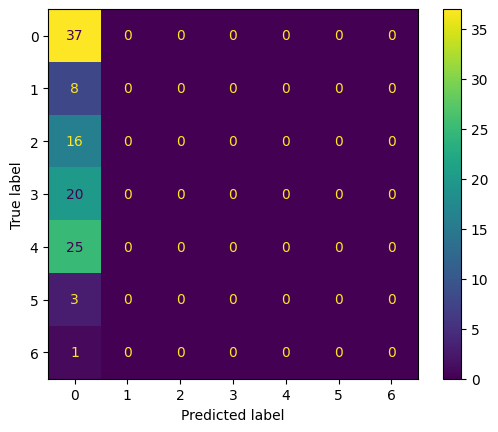

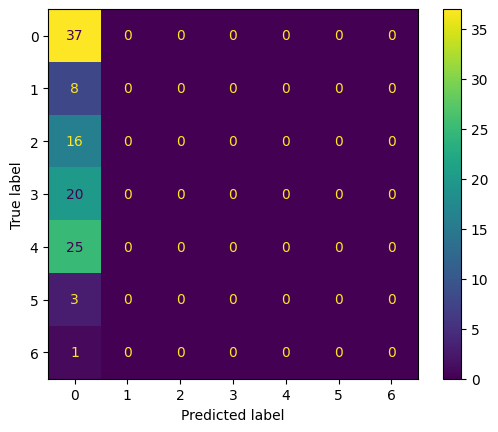

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(extract_true, extract_pred, display_labels=y_class_encodings)
disp.plot()
plt.show()

### ROC

binary cases only

In [ ]:
# fpr, tpr, thresholds = roc_curve(extract_true, extract_pred)
# roc_auc = auc(fpr, tpr)
# curve = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,estimator_name='LSTM')
# curve.plot()
# plt.show()

### Model Avg Scores

In [ ]:
print('recall',recall_score(extract_true, extract_pred, labels=y_class_encodings, average='macro'))
print('precision',precision_score(extract_true, extract_pred, labels=y_class_encodings, average='macro'))
print('f1',f1_score(extract_true, extract_pred, labels=y_class_encodings, average='macro'))
print('accuracy',accuracy_score(extract_true, extract_pred))

recall 0.14285714285714285
precision 0.048051948051948054
f1 0.07191448007774538
accuracy 0.33636363636363636
